<a href="https://colab.research.google.com/github/LuanNguyen-git/Template/blob/main/FedNAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
# ===========================
# 1. Chuẩn bị dữ liệu MNIST
# ===========================
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)

# Chia dữ liệu cho 5 client
num_clients = 5
client_size = len(x_train) // num_clients
clients = []
for i in range(num_clients):
    start = i * client_size
    end = (i + 1) * client_size
    clients.append((x_train[start:end], y_train[start:end]))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


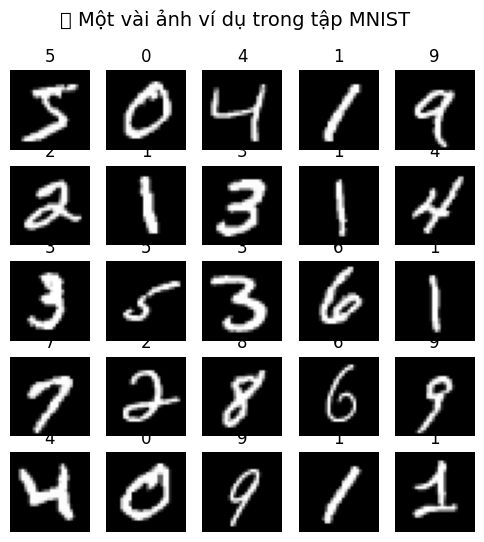

In [ ]:
import matplotlib.pyplot as plt

# Hiển thị 25 ảnh đầu tiên
plt.figure(figsize=(6,6))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(int(y_train[i]))
    plt.axis('off')
plt.suptitle("📊 Một vài ảnh ví dụ trong tập MNIST", fontsize=14)
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


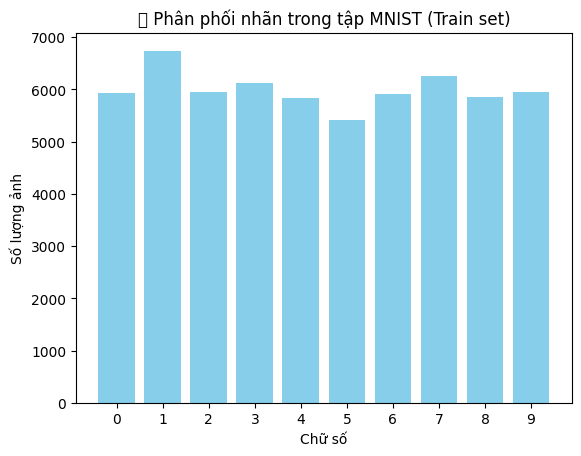

In [ ]:
import numpy as np

unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts, color='skyblue')
plt.title("📈 Phân phối nhãn trong tập MNIST (Train set)")
plt.xlabel("Chữ số")
plt.ylabel("Số lượng ảnh")
plt.xticks(unique)
plt.show()


/tmp/ipython-input-3982070485.py:11: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


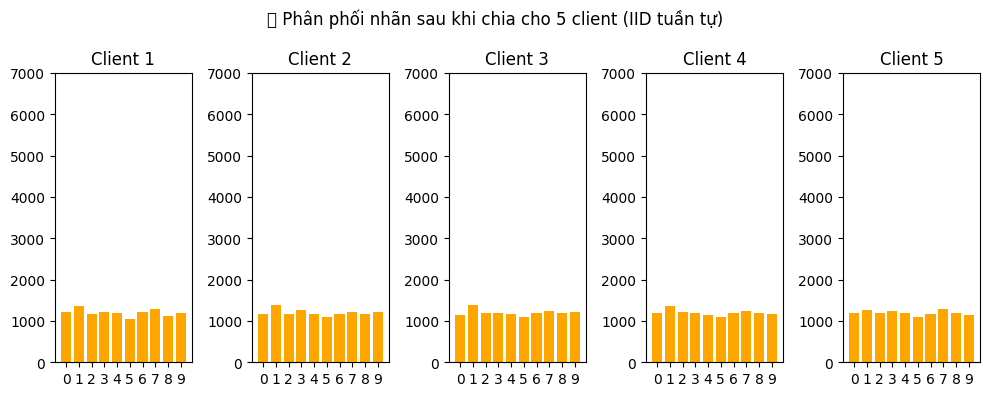

In [ ]:
# Kiểm tra phân phối nhãn của từng client
plt.figure(figsize=(10,4))
for i, (x_c, y_c) in enumerate(clients):
    unique, counts = np.unique(y_c, return_counts=True)
    plt.subplot(1,5,i+1)
    plt.bar(unique, counts, color='orange')
    plt.title(f"Client {i+1}")
    plt.xticks(unique)
    plt.ylim(0, 7000)
plt.suptitle("📦 Phân phối nhãn sau khi chia cho 5 client (IID tuần tự)")
plt.tight_layout()
plt.show()


In [ ]:
# ===========================
# 2. Định nghĩa mô hình CNN
# ===========================
def create_model():
    model = keras.Sequential([
        layers.Input(shape=(28,28,1)),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model


In [ ]:
# ===========================
# 3. Thông số huấn luyện
# ===========================
epochs_local = 2     # Số epoch mỗi client (τ)
global_rounds = 5    # Số vòng federated (K)
lr = 0.01            # Learning rate
momentum = 0.9       # Momentum cho NAG

In [ ]:
# ===========================
# 4. Hàm huấn luyện FedAvg hoặc FedNAG
# ===========================
def run_federated_training(use_nag=False):
    global_model = create_model()
    global_weights = global_model.get_weights()
    history_acc, history_loss = [], []

    for round in range(global_rounds):
        print(f"\n🌍 Global round {round+1}/{global_rounds}")
        local_weights = []

        # --- Huấn luyện cục bộ ---
        for i, (x_c, y_c) in enumerate(clients):
            print(f"  ➜ Training on client {i+1}")
            local_model = create_model()
            local_model.set_weights(global_weights)

            # 💡 Chọn optimizer:
            # FedAvg: SGD thuần túy (Gradient Descent)
            # FedNAG: SGD + momentum + nesterov
            if use_nag:
                opt = tf.keras.optimizers.SGD(
                    learning_rate=lr, momentum=momentum, nesterov=True)
            else:
                opt = tf.keras.optimizers.SGD(learning_rate=lr)

            local_model.compile(
                optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )
            local_model.fit(x_c, y_c, epochs=epochs_local, batch_size=64, verbose=0)
            local_weights.append(local_model.get_weights())

        # --- Tổng hợp toàn cục (FedAvg step) ---
        new_weights = []
        for weights in zip(*local_weights):
            new_weights.append(np.mean(weights, axis=0))
        global_weights = new_weights
        global_model.set_weights(global_weights)

        # --- Đánh giá mô hình toàn cục ---
        global_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        loss, acc = global_model.evaluate(x_test, y_test, verbose=0)
        history_acc.append(acc)
        history_loss.append(loss)

        print(f"✅ Global model accuracy: {acc:.4f}, loss: {loss:.4f}")

    return history_acc, history_loss, global_weights

In [ ]:
# ===========================
# 5. Chạy 2 mô hình: FedAvg (GD) và FedNAG
# ===========================
print("\n🚀 Training FedAvg (Gradient Descent)")
acc_avg, loss_avg, weights_avg = run_federated_training(use_nag=False)

print("\n🚀 Training FedNAG (Nesterov Accelerated Gradient)")
acc_nag, loss_nag, weights_nag = run_federated_training(use_nag=True)


🚀 Training FedAvg (Gradient Descent)

🌍 Global round 1/5
  ➜ Training on client 1
  ➜ Training on client 2
  ➜ Training on client 3
  ➜ Training on client 4
  ➜ Training on client 5
✅ Global model accuracy: 0.8918, loss: 0.4042

🌍 Global round 2/5
  ➜ Training on client 1
  ➜ Training on client 2
  ➜ Training on client 3
  ➜ Training on client 4
  ➜ Training on client 5
✅ Global model accuracy: 0.9131, loss: 0.3087

🌍 Global round 3/5
  ➜ Training on client 1
  ➜ Training on client 2
  ➜ Training on client 3
  ➜ Training on client 4
  ➜ Training on client 5
✅ Global model accuracy: 0.9223, loss: 0.2737

🌍 Global round 4/5
  ➜ Training on client 1
  ➜ Training on client 2
  ➜ Training on client 3
  ➜ Training on client 4
  ➜ Training on client 5
✅ Global model accuracy: 0.9276, loss: 0.2510

🌍 Global round 5/5
  ➜ Training on client 1
  ➜ Training on client 2
  ➜ Training on client 3
  ➜ Training on client 4
  ➜ Training on client 5
✅ Global model accuracy: 0.9326, loss: 0.2318

🚀 Trai

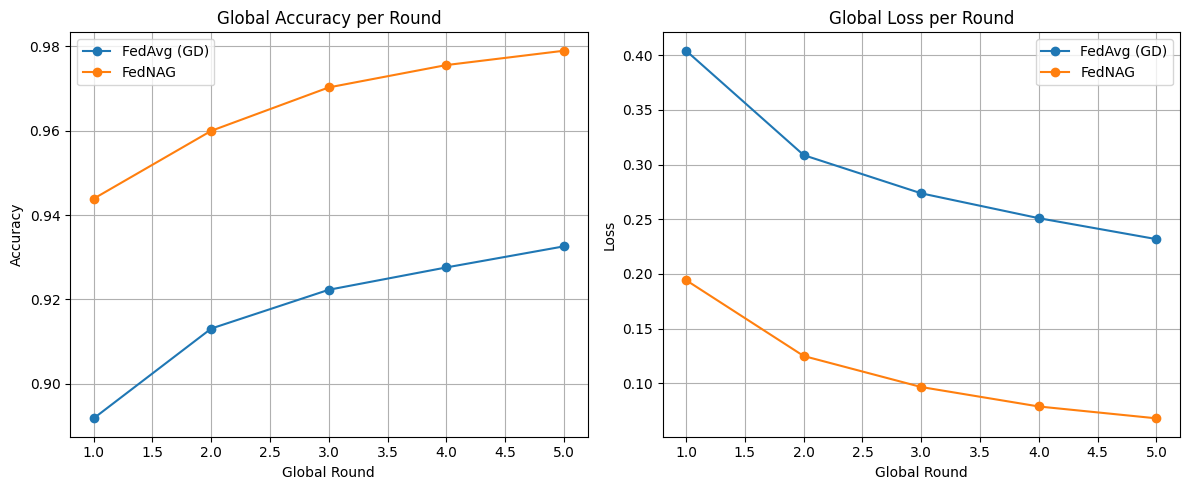

In [ ]:
# ===========================
# 6. Trực quan kết quả
# ===========================
rounds = range(1, global_rounds + 1)
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(rounds, acc_avg, marker='o', label='FedAvg (GD)')
plt.plot(rounds, acc_nag, marker='o', label='FedNAG')
plt.title("Global Accuracy per Round")
plt.xlabel("Global Round")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(rounds, loss_avg, marker='o', label='FedAvg (GD)')
plt.plot(rounds, loss_nag, marker='o', label='FedNAG')
plt.title("Global Loss per Round")
plt.xlabel("Global Round")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


📊 Confusion Matrix & Classification Report - FedAvg
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


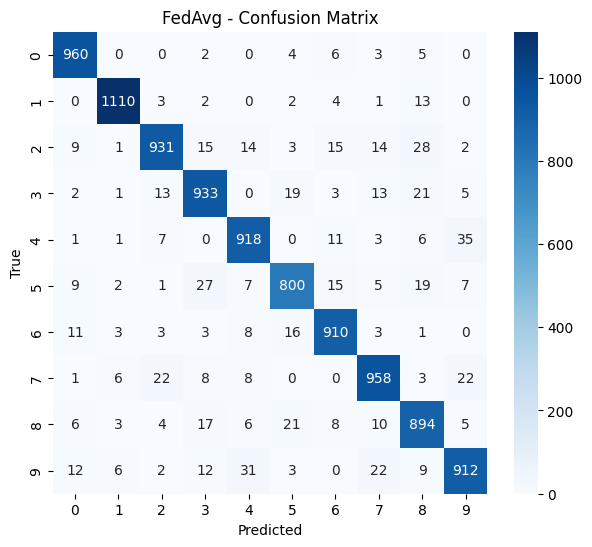

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.98      0.98      0.98      1135
           2       0.94      0.90      0.92      1032
           3       0.92      0.92      0.92      1010
           4       0.93      0.93      0.93       982
           5       0.92      0.90      0.91       892
           6       0.94      0.95      0.94       958
           7       0.93      0.93      0.93      1028
           8       0.89      0.92      0.91       974
           9       0.92      0.90      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000


📊 Confusion Matrix & Classification Report - FedNAG
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


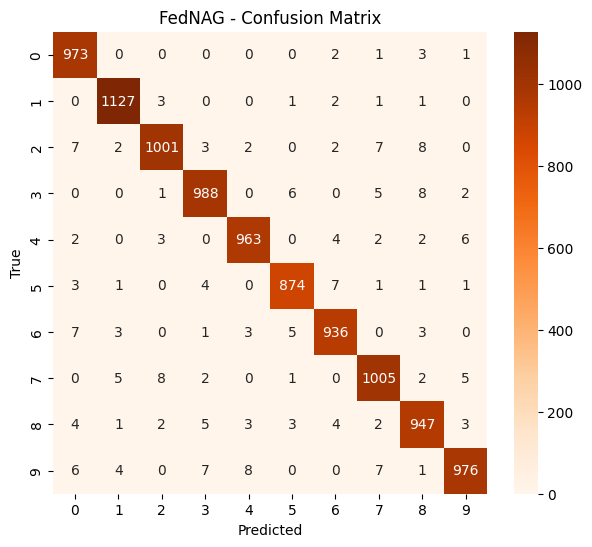

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.97      0.98      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [ ]:
# ===== Evaluate FedAvg =====
print("\n📊 Confusion Matrix & Classification Report - FedAvg")
model_avg = create_model()
model_avg.set_weights(weights_avg)
y_pred_avg = model_avg.predict(x_test).argmax(axis=1)

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm_avg = confusion_matrix(y_test, y_pred_avg)
plt.figure(figsize=(7,6))
sns.heatmap(cm_avg, annot=True, fmt='d', cmap='Blues')
plt.title("FedAvg - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_test, y_pred_avg))


# ===== Evaluate FedNAG =====
print("\n📊 Confusion Matrix & Classification Report - FedNAG")
model_nag = create_model()
model_nag.set_weights(weights_nag)
y_pred_nag = model_nag.predict(x_test).argmax(axis=1)

cm_nag = confusion_matrix(y_test, y_pred_nag)
plt.figure(figsize=(7,6))
sns.heatmap(cm_nag, annot=True, fmt='d', cmap='Oranges')
plt.title("FedNAG - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_test, y_pred_nag))


In [ ]:
unique, counts = np.unique(y_train, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Label {u}: {c} samples")

print("\nTổng số mẫu train:", len(y_train))


Label 0: 5923 samples
Label 1: 6742 samples
Label 2: 5958 samples
Label 3: 6131 samples
Label 4: 5842 samples
Label 5: 5421 samples
Label 6: 5918 samples
Label 7: 6265 samples
Label 8: 5851 samples
Label 9: 5949 samples

Tổng số mẫu train: 60000


In [ ]:
print("Class imbalance ratio:",
      max(counts) / min(counts))


Class imbalance ratio: 1.243681977494927


Bootstrap results (n_bootstrap=1000):
Accuracy: mean=0.9790, std=0.0014, 95% CI=[0.9763, 0.9818]
F1 (macro): mean=0.9789, std=0.0014, 95% CI=[0.9762, 0.9817]
Saved bootstrap results to 'bootstrap_test_only_results.csv'


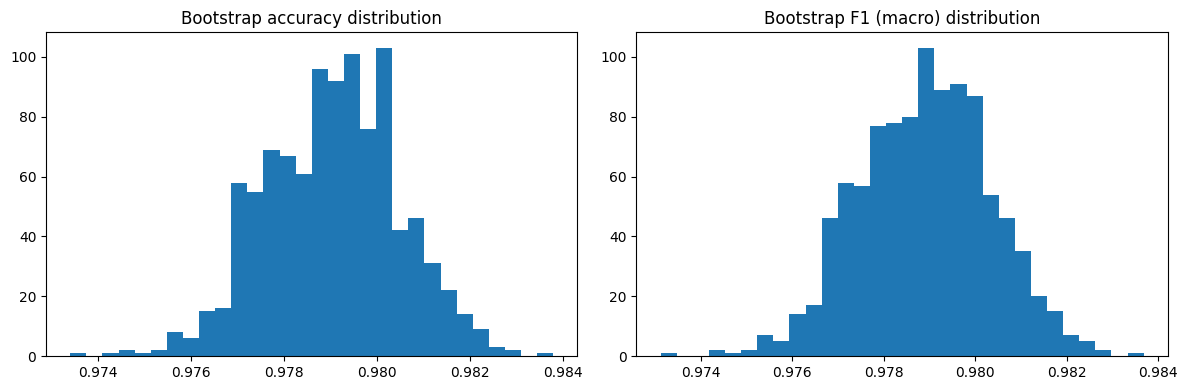

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt

# --- Config ---
n_bootstrap = 1000
rng = np.random.default_rng(42)  # reproducible
n = len(y_test)                  # kích thước test set

# Chọn y_pred bạn muốn dùng (ví dụ y_pred_nag)
# đảm bảo y_pred đã là array of labels, shape (n,)
# y_pred = y_pred_nag
y_pred = y_pred_nag  # <-- đổi nếu cần

# --- Bootstrap chỉ trên chỉ số test ---
accuracy_scores = np.empty(n_bootstrap)
f1_scores = np.empty(n_bootstrap)

for i in range(n_bootstrap):
    idx = rng.integers(0, n, n)      # bootstrap indices (with replacement)
    y_true_sample = y_test[idx]
    y_pred_sample = y_pred[idx]      # dùng y_pred gốc nhưng chỉ chọn theo idx

    accuracy_scores[i] = accuracy_score(y_true_sample, y_pred_sample)
    f1_scores[i] = f1_score(y_true_sample, y_pred_sample, average='macro')

# --- Thống kê ---
print("Bootstrap results (n_bootstrap=%d):" % n_bootstrap)
print("Accuracy: mean=%.4f, std=%.4f, 95%% CI=[%.4f, %.4f]" % (
    accuracy_scores.mean(), accuracy_scores.std(),
    np.percentile(accuracy_scores, 2.5), np.percentile(accuracy_scores, 97.5)
))
print("F1 (macro): mean=%.4f, std=%.4f, 95%% CI=[%.4f, %.4f]" % (
    f1_scores.mean(), f1_scores.std(),
    np.percentile(f1_scores, 2.5), np.percentile(f1_scores, 97.5)
))

# --- Lưu kết quả (CSV) ---
df = pd.DataFrame({
    "accuracy": accuracy_scores,
    "f1_macro": f1_scores
})
df.to_csv("bootstrap_test_only_results.csv", index=False)
print("Saved bootstrap results to 'bootstrap_test_only_results.csv'")

# --- Một số trực quan ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(accuracy_scores, bins=30)
plt.title("Bootstrap accuracy distribution")

plt.subplot(1,2,2)
plt.hist(f1_scores, bins=30)
plt.title("Bootstrap F1 (macro) distribution")
plt.tight_layout()
plt.show()


Nếu ratio gần 1.0 → dữ liệu rất cân bằng

Nếu > 1.5 → hơi lệch

Nếu > 2.0 → mất cân bằng